# Model 4: Transfer learning model with denoising and image rotation

This model utilizes transfer learning and the functional Keras API to produce a mixed convolutional model on densoised images augmented with rotation. The model utilizes the [Xception](https://keras.io/api/applications/xception/) architecture, trained on the famous [ImageNet](https://image-net.org/) image database.

In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Concatenate, Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
meta = pd.read_csv('../processed_data/train.csv', index_col=0)
augmented = pd.read_csv('../processed_data/augmented.csv', index_col=0)
meta.head()

,age_approx,Unknown,female,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity,target
0,45.0,0,0,1,1,0,0,0,0,0,0
1,45.0,0,1,0,0,0,0,0,0,1,0
2,50.0,0,1,0,0,1,0,0,0,0,0
3,45.0,0,1,0,1,0,0,0,0,0,0
4,55.0,0,1,0,0,0,0,0,0,1,0


In [3]:
augmented.head()

,age_approx,female,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity,target
0,55.0,1,0,0,0,0,0,0,1,1
1,50.0,1,0,0,0,0,0,0,1,1
2,55.0,0,1,0,0,0,0,1,0,1
3,65.0,0,1,0,0,0,0,1,0,1
4,65.0,1,0,0,1,0,0,0,0,1


In [4]:
meta = pd.concat([meta, augmented], axis=0).fillna(0)

In [5]:
meta.tail()

,age_approx,Unknown,female,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity,target
1747,55.0,0.0,0,1,0,0,0,0,0,1,1
1748,70.0,0.0,0,1,0,0,0,0,1,0,1
1749,60.0,0.0,0,1,0,0,0,0,0,1,1
1750,65.0,0.0,0,1,0,1,0,0,0,0,1
1751,60.0,0.0,0,1,1,0,0,0,0,0,1


### Metadata

In [6]:
y = meta['target'].values.reshape(-1,1)
X = meta.drop('target', axis=1)
meta_train, meta_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=867_5309)

In [7]:
meta_train = meta_train.astype('ushort')
meta_test = meta_test.astype('ushort')

In [8]:
meta_train.shape

(24414, 10)

In [9]:
y_train.shape

(24414, 1)

### Image data

In [11]:
ORIGINAL_PATH = '../processed_data/processed_train_img_array.pkl'
AUGMENTED_PATH = '../processed_data/processed_augmented_img_array.pkl'
with open(ORIGINAL_PATH, 'rb') as file:
    original_img_array = pickle.load(file)
with open(AUGMENTED_PATH, 'rb') as file:
    augmented_img_array = pickle.load(file)
img_array = np.vstack([original_img_array, augmented_img_array])
img_array = img_array.astype('ushort')
img_train, img_test, _1, _2 = train_test_split(img_array, y, test_size=0.3, random_state=867_5309) # Should split exactly the same as above

In [12]:
img_train.shape

(24414, 80, 120, 3)

In [13]:
img_test.shape

(10464, 80, 120, 3)

### Model

In [14]:
LEARNING_RATE = 0.001

# Define inputs
meta_inputs = Input(shape=(10,))
img_inputs = Input(shape=(80,120,3,))

# Model 1
meta_layer1 = Dense(4, activation='relu')(meta_inputs)

# Model 2
xception_layer = Xception(include_top=False, input_shape=(80,120,3,))(img_inputs)
img_conv_layer1 = Conv2D(8, kernel_size=(5,5), padding='same', activation='relu')(xception_layer)
img_gap_layer = GlobalAveragePooling2D()(img_conv_layer1)
img_dropout_layer = Dropout(rate=0.35, seed=42)(img_gap_layer, training=True)

# Merge models
merged_layer = Concatenate()([meta_layer1, img_dropout_layer])
merged_dense_layer = Dense(4, activation='relu')(merged_layer)
merged_output = Dense(1, activation='sigmoid')(merged_dense_layer)


# Define functional model
model = Model(inputs=[meta_inputs, img_inputs], outputs=merged_output)

# Compile model
auc = AUC(name = 'auc')
model.compile(Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=[auc])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 120, 3)] 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 3, 4, 2048)   20861480    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 3, 4, 8)      409608      xception[0][0]                   
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
______________________________________________________________________________________________

See `fchollet`'s discussion of class weights [here](https://keras.io/examples/structured_data/imbalanced_classification/).

In [10]:
weight_for_0 = 1.0 / ((len(y_train)-y_train.sum())/len(y_train))
weight_for_1 = 1.0 / (y_train.sum()/len(y_train))
class_weight = {0: weight_for_0, 1: weight_for_1}

In [15]:
epochs = 10
history = model.fit([meta_train, img_train], y_train, epochs=epochs, batch_size=40, validation_data=([meta_test, img_test], y_test), class_weight=class_weight)

Epoch 1/10
611/611 [==============================] - 109s 167ms/step - loss: 1.4683 - auc: 0.5560 - val_loss: 0.7236 - val_auc: 0.6281
Epoch 2/10
611/611 [==============================] - 102s 167ms/step - loss: 1.3433 - auc: 0.6355 - val_loss: 0.6511 - val_auc: 0.6751
Epoch 3/10
611/611 [==============================] - 101s 165ms/step - loss: 1.2826 - auc: 0.6717 - val_loss: 0.7407 - val_auc: 0.6886
Epoch 4/10
611/611 [==============================] - 101s 165ms/step - loss: 1.3222 - auc: 0.6733 - val_loss: 0.6206 - val_auc: 0.6834
Epoch 5/10
611/611 [==============================] - 101s 165ms/step - loss: 1.2656 - auc: 0.6741 - val_loss: 0.6710 - val_auc: 0.6882
Epoch 6/10
611/611 [==============================] - 101s 165ms/step - loss: 1.3082 - auc: 0.6753 - val_loss: 0.6638 - val_auc: 0.6887
Epoch 7/10
611/611 [==============================] - 100s 164ms/step - loss: 1.2905 - auc: 0.6773 - val_loss: 0.6880 - val_auc: 0.6914
Epoch 8/10
611/611 [============================

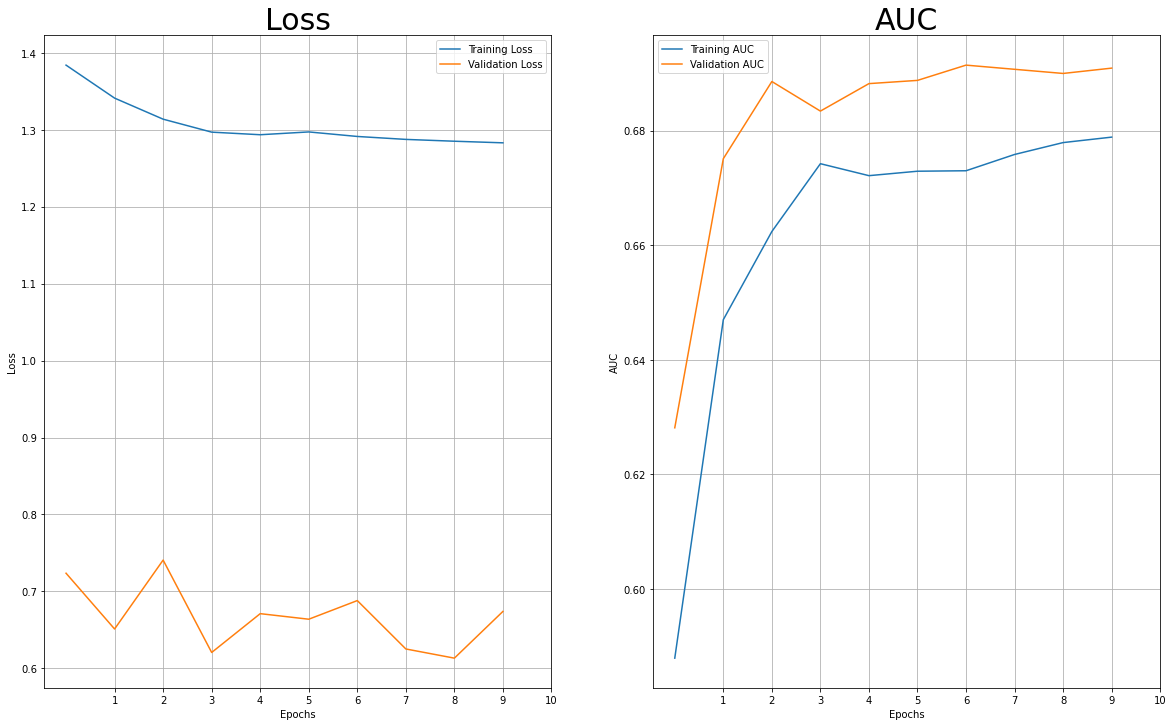

In [16]:
X = np.arange(0, epochs)

plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(X, history.history['loss'], label = 'Training Loss')
plt.plot(X, history.history['val_loss'], label = 'Validation Loss')
plt.grid(True)
plt.xticks(X+1)
plt.legend()
plt.title('Loss', fontsize=30)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.plot(X, history.history['auc'], label = 'Training AUC')
plt.plot(X, history.history['val_auc'], label = 'Validation AUC')
plt.grid(True)
plt.xticks(X+1)
plt.legend()
_ = plt.title('AUC', fontsize=30)

Model 4 has overfit the training data more than any other model thus far. We see this beginning around Epoch 5, as the training and validation AUC begin to diverge. Rotation appears to have done significant damage; perhaps there are other augmentation techniques that need to be implemented as well.

In [17]:
y_pred = model.predict([meta_test, img_test])
y_pred = np.array([int(i) for i in y_pred > 0.5])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.58      0.73      9763
           1       0.10      0.68      0.18       701

    accuracy                           0.59     10464
   macro avg       0.53      0.63      0.45     10464
weighted avg       0.90      0.59      0.69     10464

